In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Gaussian Processes (Noiseless setting)
Discriminative Models (usually linear or generalized linear model) are limited in terms of performance (e.g. unable  arn non linear patterns). In order to learn non linear functions, Gussian processes replaces $w^T \mathbf{x}$ by $f(\mathbf{x})$ which is a non linear function of $\mathbf{x}$. Hence, in GP the goal is to learn $f(\mathbf{x})$ instead of the weight vector $w$ in a bayesian framework. Gaussian Processes is essentially a Bayesian approach to kernel based non linear learning. GP is defined as distribution over functions and is denoted as:
$$GP(\mu(.), \kappa(.,.)) \equiv \mathcal{N}(\mu(.), \kappa(.,.))$$
Every sample from the distribution $GP(\mu, \kappa)$ will give a random function $f$ where $f$ is an inf. dim. vector of function values at different inputs ($\mathbf{x}$) i.e. $f = [f(\mathbf{x}_1), f(\mathbf{x}_2), \dots, f(\mathbf{x}_N)]$. Here, since no noise is added to $f(\mathbf{x}_n)$, it is called Noiseless setting.

GPs are defined in function space (rather than weight space). Assuming we know,  $f = [f(\mathbf{x}_1), f(\mathbf{x}_2), \dots, f(\mathbf{x}_N)]^T$, the joint distribution can be defined as

$$p(f) = \mathcal{N}(\mu,\mathbf{K})$$

where $\mu = [\mu(\mathbf{x}_1), \mu(\mathbf{x}_2), \dots, \mu(\mathbf{x}_N)]^T$ and

$\mathbf{K}$ = \begin{bmatrix} 
    \kappa(x_1, x_1) & \kappa(x_1, x_2) & \dots & \kappa(x_1, x_N)\\
    \kappa(x_2, x_1) & \kappa(x_2, x_2) & \dots & \kappa(x_2, x_N)\\
    \vdots & \vdots & \ddots &\\
    \kappa(x_N, x_1) & \kappa(x_N, x_2) & \dots & \kappa(x_N, x_N)
    \end{bmatrix}
 
Furthermore, when we assume $\mu = [0, 0, \dots, 0]^T$, We get,
$$p(f) = \mathcal{N}(\mathbf{0},\mathbf{K})$$
In order to predict $f(x_*)$, we gaussian property and derive,

$$p\left(\begin{bmatrix} 
    f \\ f_* \end{bmatrix}\right) = \mathcal{N}\left(\begin{bmatrix} 
    0 \\ 0 \end{bmatrix},\begin{bmatrix} 
    \mathbf{K} & \mathbf{k}_* \\ \mathbf{k}_*^T & \kappa(x_*, x_*) \end{bmatrix}\right)$$
 where $\mathbf{k}_* = [\kappa(x_1, x_*), \kappa(x_2, x_*), \dots, \kappa(x_N, x_*)]^T$.
 
 Using the conditional property of Gaussian Distribution we can write,
 
 $$p(f_*|f) = \mathcal{N}(\mathbf{k}_*^T \mathbf{K}^{-1}f ,\kappa(x_*, x_*) - \mathbf{k}_*^T \mathbf{K}^{-1}\mathbf{k}_*) $$
 
__Implementation:__ The data is generated using a sinusoid function. In the range between "lowrange" and "uprange", a few points are randomly selected, which denotes the data. Using GP, the function value is predicted along with its uncertainity (using the formulas above). These are further plotted where blue curve represents mean prediction and the red are represents corresponding uncertainity.

# Custom Functions

In [99]:
def createData(N,lowrange,uprange):
    '''
    Creating Data points X and corresponding outputs Y using SINUSOID FUNCTION
    Input:
        N: No. of data points to be generated 
        
    Output:
        X: np vector of shape (N,)
        Y: np vector of shape (N,)
    '''
    s = np.random.uniform(lowrange,uprange,N)
    X = np.sort(s, axis=None)
    #Y = np.sin(X * np.pi / 180.)
    Y = np.sin(X)
    return X, Y

def KernelSExp(sig, l, x1, x2):
    '''
    Generate Squared Exponential Kernel for inputs x1 and x2
    Input:
        sig: scalar
        l: scalar
        x1: scalar data point 1
        x2: scalar data point 2
    Output:
        kse: scalar output of square exponential kernel for x1 and x2
    '''
    kse = (sig**2) * np.exp(-((x1-x2)**2)/(2*l*l))
    return kse

def createKernelMatrix(X,KernelValFunc, sig, l):
    '''
    Creating Kernel Matrix for function data points X a using  KernelFunc
    Input:
        X: Data points -  np vector of shape (N,)
        KernelFunc: The function used to compute kernels
        
    Output:
        K: np matrix of shape (N,N)
    '''
    N = len(X)
    K  = np.zeros((N,N))
    for i in range(N):
        for j in range (N):
            K[i,j] = KernelValFunc(sig, l, X[i], X[j])
    return K

def GeneratePriorGPsamples(NoSamples, X, KernelFunc, sig, l):
    '''
    Sampling from GP Prior with Zero Mean and Kernel Matrix as Covariance
    Input:
        NoSample = Number of Samples to be derieved from GP Prior
        X: No. of data points to be generated -  np vector of shape (N,)
        KernelFunc: The function used to compute kernels
    Output:
        Ymat: np matrix of shape (NoSample, N)
    '''
    N = len(X)
    Mean = np.zeros(N)
    K  = createKernelMatrix(X,KernelFunc, sig, l)
    Y = np.random.multivariate_normal(Mean, K, NoSamples)
    return Y

def ComputeGP_PPDmeancov(x_new, X, Y, KernelFunc, KernelValFunc, sig, l):
    '''
    Computing PPD mean for GP PPD
    Input:
        x_new = new data point - scalar
        X: Data points -  np vector of shape (N, )  
        Y: Output at Data points -  np vector of shape (N, )
        KernelFunc: The function used to compute kernel matrix
        KernelValFunc: The function used to compute kernel value for particular data pair
    Output:
        GP_PPD_Mean: scalar
        GP_PPD_Cov: scalar
    '''
    N  = len(X)
    K  = createKernelMatrix(X,KernelValFunc, sig, l)
    kernelval_new = KernelValFunc(sig, l, x_new, x_new)
    k_new = np.zeros(N)
    for i in range(N):
        k_new[i] = KernelValFunc(sig, l, X[i], x_new)
    
    K_inv = np.linalg.inv(K)
    GP_PPD_Mean = k_new@K_inv@Y
    GP_PPD_Cov = kernelval_new - k_new@K_inv@k_new
    return GP_PPD_Mean, GP_PPD_Cov

In [162]:
lowrange = -5
uprange = 5
N = 5
sig = 2
l = 2
NoSamples = 50
X, Y = createData(N,lowrange,uprange)

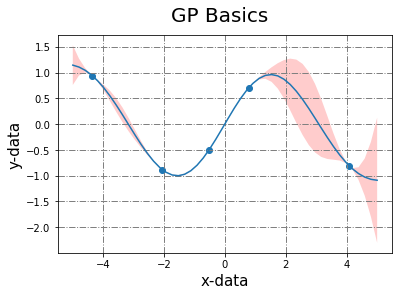

In [163]:
XX = np.linspace(lowrange, uprange, num=NoSamples)
PPD_MeanCov = np.zeros((NoSamples,2))
for i in range(len(XX)):
    PPD_MeanCov[i,0], PPD_MeanCov[i,1]  = ComputeGP_PPDmeancov(XX[i], X, Y, createKernelMatrix, KernelSExp, sig, l)
    

plot1 = plt.figure(1)
plt.scatter(X,Y)
plt.plot(XX,PPD_MeanCov[:,0])
a1 = PPD_MeanCov[:,0] - 2*PPD_MeanCov[:,1]
a2 = PPD_MeanCov[:,0] + 2*PPD_MeanCov[:,1]
plt.fill_between(XX, a1, a2, facecolor='r', alpha=0.2)
plt.xlabel('x-data', fontsize=15)
plt.ylabel('y-data', fontsize=15)
plt.suptitle('GP Basics', fontsize=20)
plt.grid(True, color = "grey", linewidth = "1", linestyle = "-.")
plt.show()